# Label-free classification using SCIP features

## Package imports

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from scip_workflows.common import *


In [19]:
import pickle
import shap
import sklearn.base
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import spearmanr
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    minmax_scale,
    normalize,
    scale,
)
from sklearn.svm import SVC
from xgboost import XGBClassifier

from scip_workflows import core

shap.initjs()


In [20]:
plt.rcParams["figure.dpi"] = 200


## Data import

In [32]:
try:
    features = snakemake.input.features
    index = snakemake.input.index
    columns = snakemake.input.columns
    labels = snakemake.input.labels
    hpo_full = snakemake.input.hpo_full
    hpo_cyto = snakemake.input.hpo_cyto
    output_confmat_full = snakemake.output.confmat_full
    output_confmat_cyto = snakemake.output.confmat_cyto
    output_metrics_full = snakemake.output.metrics_full
    output_metrics_cyto = snakemake.output.metrics_cyto
except NameError:
    data_root = Path("/home/maximl/scratch/data/vsc/datasets/wbc/")
    # data_root = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/wbc"
    data_scip = data_root / "scip/20220713131400/"
    features = data_scip / "WBC_features.parquet"
    index = data_scip / "indices/index.npy"
    columns = data_scip / "indices/columns.npy"
    labels = data_scip / "labels.parquet"
    hpo_full = data_scip / "hpo" / "WBC_rsh+innersample_scip_full_li_xgboost.pickle"
    hpo_cyto = data_scip / "hpo" / "WBC_rsh_scip_cyto_li_xgboost.pickle"
    output_confmat_full = data_scip / "figures" / "WBC_scip_full_cv_confmat.png"
    output_confmat_cyto = data_scip / "figures" / "WBC_scip_cyto_cv_confmat.png"
    output_metrics_full = data_scip / "figures" / "WBC_scip_full_cv_metrics.png"
    output_metrics_cyto = data_scip / "figures" / "WBC_scip_cyto_cv_metrics.png"


In [22]:
df_scip = pq.read_table(features).to_pandas()

df_scip = df_scip[numpy.load(columns, allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(index, allow_pickle=True)]

labels = pq.read_table(labels).to_pandas()
df_scip = df_scip.merge(labels, left_index=True, right_index=True)
# df_scip["meta_label"] = pandas.Categorical(df_scip["meta_label"], ordered=True)

df_scip.shape


(218404, 3923)

In [23]:
df_scip["meta_label"].value_counts()


CD15 + Neutrophils    132536
CD4 T cells            32183
CD8 T cell             13899
unknown                13248
CD19 pos B cells        8408
CD56+ NK Cells          6207
NK T cells              4231
CD14+ Monocyte          4041
Eosinophils             3651
Name: meta_label, dtype: int64

In [24]:
df = df_scip


In [25]:
df.shape


(218404, 3923)

## Continue with events assigned to cell states

I filter out the events falling between manual gates. This is only a small amount of events

In [26]:
df = df.loc[df["meta_label"] != "unknown"].copy()
df.shape


(205156, 3923)

In [27]:
df["meta_label"] = df["meta_label"].astype("category")


In [28]:
enc = LabelEncoder().fit(df["meta_label"])


## Classification and feature analysis using an Extreme Gradient Boosting classifier

### Tuning hyper parameters

We inspect the results from recursive successive halving hyper parameter optimization

In [33]:
with open(hpo_full, "rb") as fh:
    grid_full = pickle.load(fh)


[08:13:54] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


In [36]:
param_distributions = {
    "xgbclassifier__max_depth": [7, 6, 5, 4, 3, 2],
    "xgbclassifier__learning_rate": [0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.001],
    "xgbclassifier__subsample": numpy.arange(start=0.1, stop=1.1, step=.1),
    "xgbclassifier__colsample_bytree": numpy.arange(start=0.1, stop=1.1, step=.1),
    "xgbclassifier__gamma": numpy.arange(start=0, stop=31, step=2),
    "xgbclassifier__min_child_weight": numpy.arange(start=1, stop=32, step=2)
    # "xgbclassifier__n_estimators": numpy.arange(start=10, stop=301, step=10)
}

In [37]:
pandas.set_option("display.max_colwidth", 1000)


In [39]:
tmp_df = pandas.DataFrame([e.best_params_ for e in grid_full["estimator"]]).T
for k, v in param_distributions.items():
    if type(v[0]) is numpy.float64:
        tmp_df.loc[k, "tested values"] = ", ".join(["%.2f" % i for i in v])
    else:
        tmp_df.loc[k, "tested values"] = ", ".join([str(i) for i in v])
tmp_df.index = [c[len("xgbclassifier__") :] for c in tmp_df.index]
tmp_df
# print(tmp_df.to_latex(float_format="%.2f", escape=False))


,0,tested values
subsample,0.7,"0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00"
min_child_weight,29.0,"1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31"
max_depth,6.0,"7, 6, 5, 4, 3, 2"
learning_rate,0.2,"0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.001"
gamma,26.0,"0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30"
colsample_bytree,0.3,"0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00"
n_estimators,640.0,NaN


In [ ]:
grid_full["test_balanced_accuracy"].mean(), scipy.stats.sem(
    grid_full["test_balanced_accuracy"]
)


In [34]:
grid_full["test_balanced_accuracy"], grid_full["train_balanced_accuracy"]


(array([0.54030115]), array([0.81329079]))

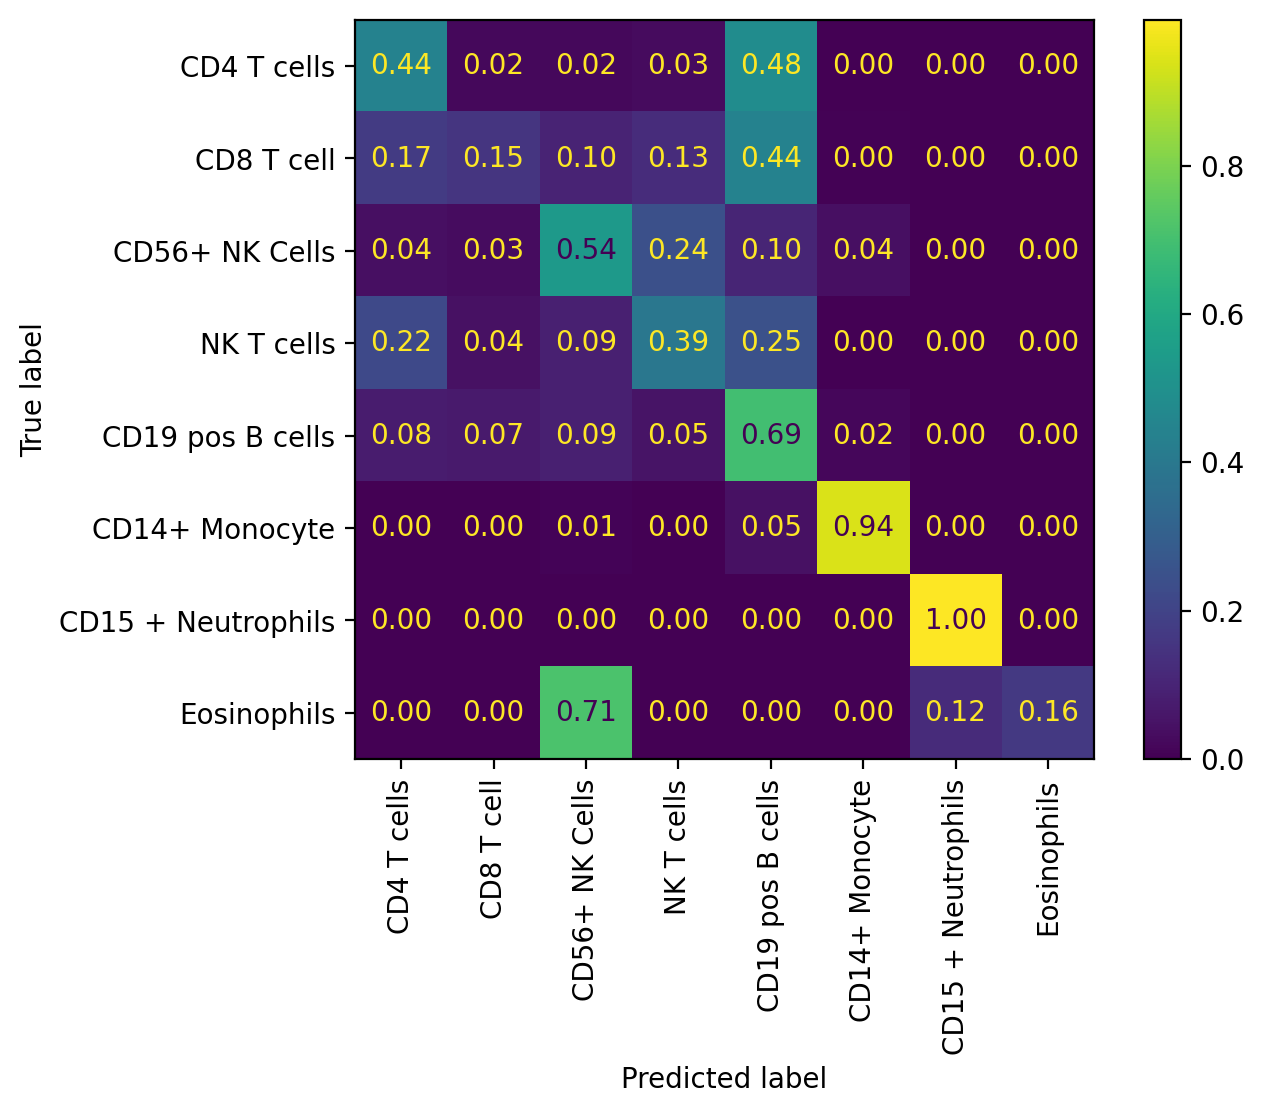

In [35]:
from sklearn.model_selection import PredefinedSplit

X = df.filter(regex=".*_li_.*(BF1|BF2|SSC)$")
y = enc.transform(df["meta_label"])
preds = []
true = []

test_fold_outer = df.index.to_frame().apply(
    lambda x: 0 if (x["meta_group"] == 2) and (x["meta_fix"] == "early") else -1,
    axis="columns"
).values 
outer_cv = PredefinedSplit(test_fold_outer)
# outer_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid_full["estimator"], outer_cv.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true,
    preds,
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize="true",
    xticks_rotation="vertical",
    values_format=".2f",
    ax=ax,
)
plt.savefig(output_confmat_full, bbox_inches="tight")


In [ ]:
grid_full_df = (
    pandas.DataFrame(grid_full)
    .drop(columns=["score_time", "fit_time", "estimator"])
    .melt()
)
grid_full_df["phase"] = grid_full_df["variable"].apply(lambda r: r.split("_")[0])
grid_full_df["metric"] = grid_full_df["variable"].apply(
    lambda r: " ".join(r.split("_")[1:])
)

seaborn.swarmplot(data=grid_full_df, x="value", y="metric", hue="phase")

plt.savefig(output_metrics_full, bbox_inches="tight")


In [ ]:
scores_df = grid_full_df.groupby(["metric", "phase"])["value"].agg(
    ["mean", scipy.stats.sem]
)
scores_df.index.names = ["Metric", "Phase"]
scores_df["Mean (std. error)"] = scores_df.apply(
    lambda r: "%.3f (%.3f)" % (r["mean"], r["sem"]), axis=1
)
scores_df = scores_df.reset_index().pivot(
    index="Metric", values="Mean (std. error)", columns="Phase"
)
scores_df.index.name = ""

print(scores_df.style.to_latex(hrules=True))


In [16]:
with open(hpo_cyto, "rb") as fh:
    grid_cyto = pickle.load(fh)


[14:04:41] WARNING: ../src/learner.cc:256: Only 1 GPUs are visible, setting `gpu_id` to 0


In [17]:
grid_cyto["test_balanced_accuracy"].mean(), scipy.stats.sem(
    grid_cyto["test_balanced_accuracy"]
)


Degrees of freedom <= 0 for slice
invalid value encountered in double_scalars


(0.4915209288007166, nan)

In [19]:
grid_cyto["train_balanced_accuracy"].mean(), scipy.stats.sem(
    grid_cyto["train_balanced_accuracy"]
)


Degrees of freedom <= 0 for slice
invalid value encountered in double_scalars


(0.907375771466586, nan)

In [20]:
grid_cyto["test_balanced_accuracy"], grid_cyto["train_balanced_accuracy"]


(array([0.49152093]), array([0.90737577]))

In [ ]:
X = (
    df.drop("late", level="meta_fix")
    .drop(0, level="meta_group")
    .filter(regex="(BF1|BF2|SSC)$")
)  # .fillna(0)
y = enc.transform(
    df.drop("late", level="meta_fix").drop(0, level="meta_group")["meta_label"]
)
preds = []
true = []

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid_cyto["estimator"], skf.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true,
    preds,
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize="true",
    xticks_rotation="vertical",
    values_format=".2f",
    ax=ax,
)
plt.savefig(output_confmat_cyto, bbox_inches="tight")


In [ ]:
grid_cyto_df = (
    pandas.DataFrame(grid_cyto)
    .drop(
        columns=[
            "score_time",
            "fit_time",
            "estimator",
            "train_recall_macro",
            "test_recall_macro",
        ]
    )
    .melt()
)
grid_cyto_df["phase"] = grid_cyto_df["variable"].apply(lambda r: r.split("_")[0])
grid_cyto_df["metric"] = grid_cyto_df["variable"].apply(
    lambda r: " ".join(r.split("_")[1:])
)

seaborn.swarmplot(data=grid_cyto_df, x="value", y="metric", hue="phase")

plt.savefig(output_metrics_cyto, bbox_inches="tight")


In [ ]:
scores_df = grid_cyto_df.groupby(["metric", "phase"])["value"].agg(
    ["mean", scipy.stats.sem]
)
scores_df.index.names = ["Metric", "Phase"]
scores_df["Mean (std. error)"] = scores_df.apply(
    lambda r: "%.3f (%.3f)" % (r["mean"], r["sem"]), axis=1
)
print(
    scores_df.reset_index()
    .pivot(index="Metric", values="Mean (std. error)", columns="Phase")
    .style.to_latex(hrules=True)
)
